### Introducing the `GriddedData` class

This notebook introduces basic features of the [GriddedData](http://aerocom.met.no/pya/api.html#pya.griddeddata.GriddedData) class of pyaerocom. The `GriddedData` class is the fundamental base class for the analysis of model data. The underlying data type is [iris.cube.Cube](http://scitools.org.uk/iris/docs/latest/iris/iris/cube.html#iris.cube.Cube) which was extended, for instance by allowing direct imports of netCDF files when creating an instance of `GriddedData` (i.e. by passing the filename and specifying the variable name on initialisation). This notebook introduces some of the features of the `GriddedData` class. Starting with some imports...

In [1]:
import pyaerocom as pya
from warnings import filterwarnings
filterwarnings('ignore')
pya.change_verbosity('critical')

Initating pyaerocom configuration


Checking database access...


Checking access to: /lustre/storeA


Access to lustre database: True


Init data paths for lustre


Expired time: 0.017 s


Let's get a test file to load

In [2]:
test_files = pya.io.testfiles.get()
for name, filepath in test_files["models"].items(): print("%s\n%s\n" %(name, filepath))

aatsr_su_v4.3
/lustre/storeA/project/aerocom/aerocom-users-database/CCI-Aerosol/CCI_AEROSOL_Phase2/AATSR_SU_v4.3/renamed/aerocom.AATSR_SU_v4.3.daily.od550aer.2008.nc

ecmwf_osuite
/lustre/storeA/project/aerocom/aerocom1/ECMWF_OSUITE_NRT_test/renamed/aerocom.ECMWF_OSUITE_NRT_test.daily.od550aer.2018.nc



Let's pick out the ECMWF OSUITE test file and load the data directly into an instance of the `GriddedData` class. The `GriddedData` class takes either preloaded instances of the `iris.cube.Cube` class as input, or a valid netCDF file path. The latter requires specification of the variable name which is then filtered from the data stored in the netCDF file (which may contain multiple variables. The following example imports the data for the aerosol optical density at 550 nm. The string representation of the `GriddedData` class (see print at end of following code cell) was slitghtly adapted from the underlying `Cube` object.

In [3]:
fpath = test_files["models"]["ecmwf_osuite"]
data = pya.GriddedData(input=fpath, var_name="od550aer", name="ECMWF_OSUITE")
print(data)

pyaerocom.GriddedData: n/d
Grid data: Dust Aerosol Optical Depth at 550nm / (unknown) (time: 365; latitude: 451; longitude: 900)
     Dimension coordinates:
          time                                       x              -               -
          latitude                                   -              x               -
          longitude                                  -              -               x
     Attributes:
          Conventions: CF-1.0
          NCO: 4.7.2
          history: Tue Mar 20 13:08:49 2018: ncks -7 -O -o test.nc -x -v time_bnds od550aer.test.orig.nc
Tue...
          history_of_appended_files: Tue Mar 20 02:09:15 2018: Appended file /lustre/storeA/project/aerocom/aerocom1/ECMWF_OSUITE_NRT/renamed//aerocom.ECMWF_OSUITE_NRT.daily.od550bc.2018.nc...
          invalid_units: ~
          nco_openmp_thread_number: 1
     Cell methods:
          mean: time


#### Remark on longitude definition

<div class="alert alert-block alert-info"> 
If the longitudes in the original NetCDF file are defined as

$$0 \leq\,\text{lon}\,\leq360$$

they are converted automatically to 

$$-180\leq\,\text{lon}\,\leq180$$

when an instance of the `GriddedData` class is created (see print statment above *Rolling longitudes to -180 -> 180 definition*). This is, for instance, the case for the ECMWF OSUITE data files.
</div>

#### Features of the `GriddedData` class

In the following cell, some of the most important attributes are introduced. These are mostly reimplementations of the underlying `Cube` data which is stored in the `GriddedData.grid` attribute. For instance the attribute `GriddedData.longitude` get's you `GriddedData.grid.coord("longitude")`, `GriddedData.latitude` get's you `GriddedData.grid.coord("latitude")` and `GriddedData.time` get's you `GriddedData.grid.coord("time")`. 

In [4]:
print(data.var_name)
print(type(data.longitude))
print("Longitude attr is pointer to DimCoord instance of underlying Cube: %s" %(data.longitude is data.grid.coord("longitude")))
print(data.longitude.points.min(), data.longitude.points.max())
print(data.latitude.points.min(), data.latitude.points.max())
print(data.time.points.min(), data.time.points.max())
tstamps = data.time_stamps()
print(tstamps[0], tstamps[-1])

od550aer
<class 'iris.coords.DimCoord'>
Longitude attr is pointer to DimCoord instance of underlying Cube: True
-180.0 179.60000610351562
-90.0 90.0
0.0 364.0
2018-01-01T00:00:00.000000 2018-12-31T00:00:00.000000


If you do not specify the variable type, an Exception is raised, that will get you some information about what variables are available in the file (if the file is readable using the `iris.load` method).

In [5]:
try:
    data = pya.GriddedData(input=fpath)
except pya.exceptions.NetcdfError as e:
    print("This did not work...error message: %s" %repr(e))

This did not work...error message: NetcdfError("Could not load single cube from /lustre/storeA/project/aerocom/aerocom1/ECMWF_OSUITE_NRT_test/renamed/aerocom.ECMWF_OSUITE_NRT_test.daily.od550aer.2018.nc. Please specify var_name. Input file contains the following variables: ['od550aer', 'od550so4', 'od550bc', 'od550dust', 'od550oa']",)


Also, if you parse an invalid variable name, you will get some hint.

In [6]:
try:
    data = pya.GriddedData(input=fpath, var_name="Blaaa")
except Exception as e:
    print("This also did not work...error message: %s" %repr(e))

This also did not work...error message: NetcdfError('Variable Blaaa not available in file /lustre/storeA/project/aerocom/aerocom1/ECMWF_OSUITE_NRT_test/renamed/aerocom.ECMWF_OSUITE_NRT_test.daily.od550aer.2018.nc',)


You can have a quick look at the data using the class-own quickplot method

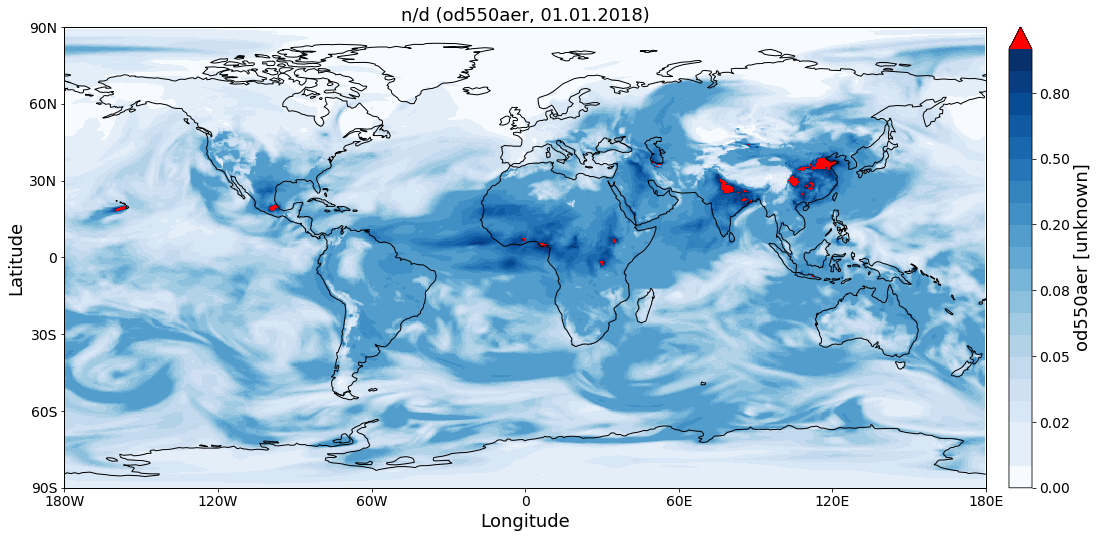

In [7]:
fig = data.quickplot_map(time_idx=0, 
                         vmin=0, 
                         vmax=1, 
                         c_over="r")

Why not load some of the other variables...

In [8]:
data_bc = pya.GriddedData(fpath, var_name="od550bc", name="ECMWF_OSUITE")
data_so4 = pya.GriddedData(fpath, var_name="od550so4", name="ECMWF_OSUITE")

... and plot them as well

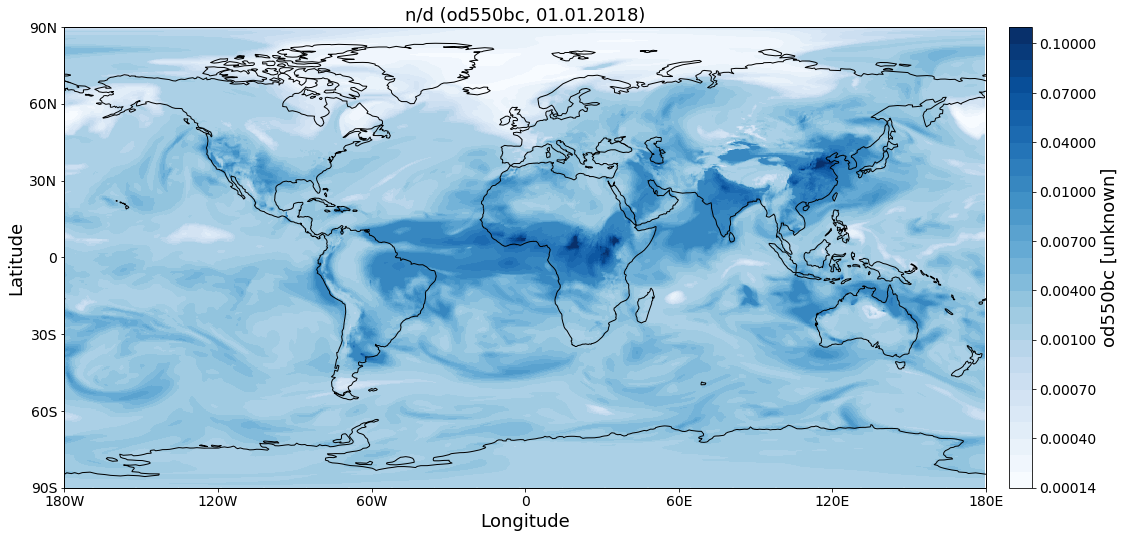

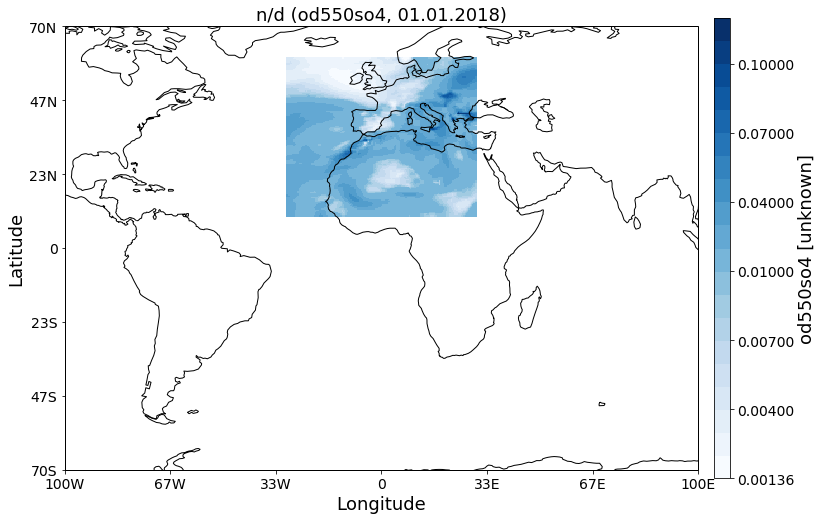

In [9]:
fig1 = data_bc.quickplot_map()
fig2 = data_so4.crop(lon_range=(-30, 30), 
                     lat_range=(10, 60)).quickplot_map(xlim=(-100, 100), 
                                                       ylim=(-70, 70))

#### Change resolution

Downscale to 2x2 resolution:

In [10]:
lons = np.arange(-180, 180, 2)
lats = np.arange(-90, 90, 2)

data_lowres = data.interpolate(longitude=lons, latitude=lats)

Interpolating data of shape (365, 451, 900). This may take a while.


Successfully interpolated cube


And plot:

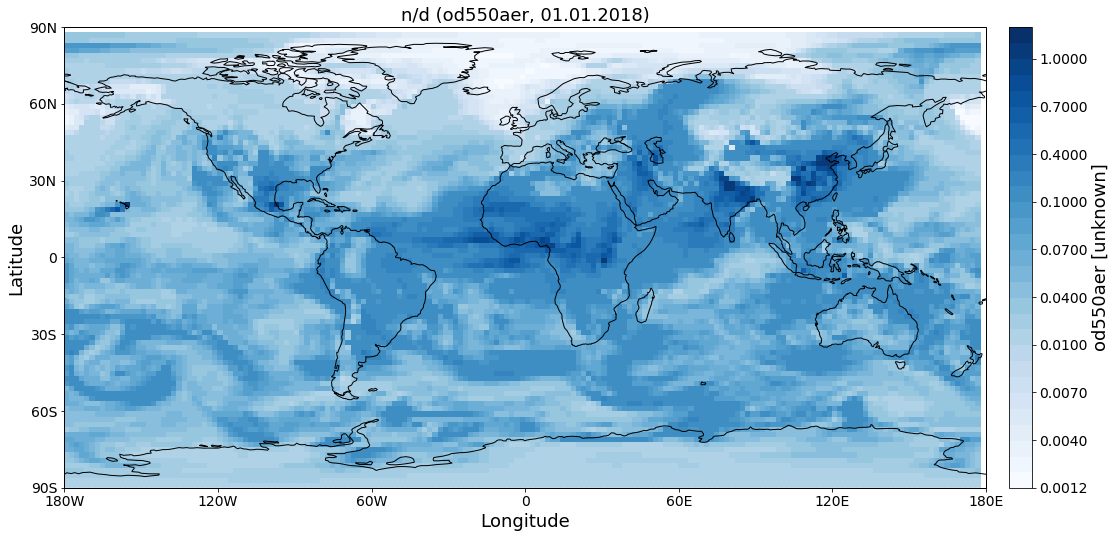

In [11]:
fig =data_lowres.quickplot_map()

#### Area weighted mean

Retrieve area weighted mean from data

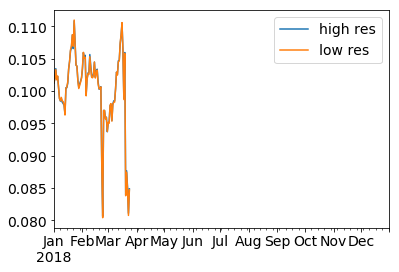

In [12]:
import pandas as pd
mean_highres = data.area_weighted_mean()
mean_lowres = data_lowres.area_weighted_mean()
s_highres = pd.Series(mean_highres, data.time_stamps())
s_lowres = pd.Series(mean_lowres, data.time_stamps())

ax = s_highres.plot(label='high res')
ax = s_lowres.plot(ax=ax, label = 'low res')
ax.legend()

Looks similar (which is good).

#### ... more to come

This tutorial is not yet completed as the `GriddedData` class is currently under development.